# Transaction Costs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

#### Almgren et al (2005)
This model assumes the initial order, X, is completed at a uniform rate of trading over a volume time interval T. That is, the trade rate in volume units is v = X/T, and is held constant until the trade is completed. Constant rate in these units is equivalent to VWAP execution during the time of execution.

In [18]:
def perm_impact(pct_adv, annual_vol_pct = 0.25, inv_turnover = 200):
    gamma = 0.314
    return 10000 * gamma * (annual_vol_pct / np.sqrt(250)) * pct_adv * (inv_turnover)**0.25

def temp_impact(pct_adv, minutes, annual_vol_pct = 0.25, minutes_in_day = 60*6.5):
    eta = 0.142
    day_frac = minutes / minutes_in_day
    return 10000 * eta * (annual_vol_pct / np.sqrt(250)) * abs(pct_adv/day_frac)**0.6

def tc_bps(pct_adv, minutes, annual_vol_pct = 0.25, inv_turnover = 200):
    """
    pct_adv: percentage of average daily volume
    minutes: number of minutes
    annual_vol_pct: annual volatility
    inv_turnover: inverse of number of shares traded on a daily basis as a percentage of total number of shares
    """
    perm = perm_impact(pct_adv, annual_vol_pct=annual_vol_pct, inv_turnover=inv_turnover)
    temp = temp_impact(pct_adv, minutes, annual_vol_pct=annual_vol_pct, minutes_in_day=0.1*60*6.5)
    return 0.5 * perm + temp

**Speed of execution vs Transaction Cost**

We are trading 10\% of ADV of a stock with a daily vol of 1.57\%. Assume an inverse turnover equal to 200:

In [22]:
annual_vol = 0.0157*np.sqrt(250)

fast = tc_bps(pct_adv=0.1, minutes=40, annual_vol_pct=annual_vol, inv_turnover=200)
medium = tc_bps(pct_adv=0.1, minutes=90, annual_vol_pct=annual_vol, inv_turnover=200)
slow = tc_bps(pct_adv=0.1, minutes=240, annual_vol_pct=annual_vol, inv_turnover=200)

print('Cost to trade Fast   (First 40 mins) :', round(fast,2), 'bps')
print('Cost to trade Medium (First 90 mins) :', round(medium,2), 'bps')
print('Cost to trade Slow   (First 240 mins):', round(slow,2), 'bps')

Cost to trade Fast   (First 40 mins) : 14.79 bps
Cost to trade Medium (First 90 mins) : 12.66 bps
Cost to trade Slow   (First 240 mins): 11.15 bps


**Specific Example**

Let's say we wanted to trade $2M notional of a stock trading at a share price of 110.89. The average daily volume is equal to 30M shares and the market cap of the firm is 275 Billion. Assume an annual volatility of 0.22. What would be the transaction cost if we performed this transaction in 15 minutes?

In [26]:
trade_notional = 2000000 # 2M notional
stock_price = 110.89 # dollars per share
shares_to_trade = trade_notional/stock_price
stock_adv_shares = 30e6 # 30 M
stock_shares_outstanding = 275e9/110.89
pct_adv = shares_to_trade/stock_adv_shares

expected_tc = tc_bps(pct_adv, minutes=15, annual_vol_pct=0.22)
print("Expected tc in bps: %0.2f" % expected_tc)
print("Expected tc in $ per share: %0.2f" % (expected_tc*stock_price / 10000))

Expected tc in bps: 0.46
Expected tc in $ per share: 0.01


Explore the relationship between execution time (in minutes) and the transaction cost:

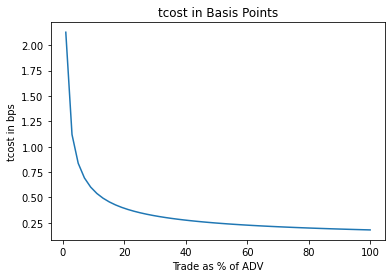

In [31]:
x = np.linspace(1, 100)
plt.plot(x, tc_bps(pct_adv, x, 0.22));
plt.ylabel('tcost in bps')
plt.xlabel('Trade as % of ADV')
plt.title(r'tcost in Basis Points');

**Distinction between permanent and temporary impact**

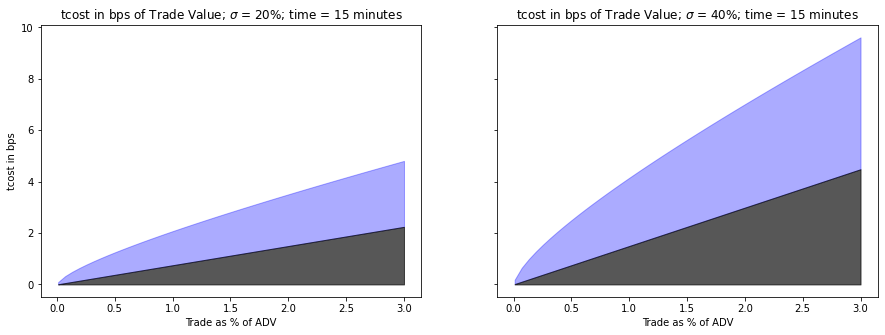

In [34]:
minutes = 30
x = np.linspace(0.0001,0.03)

f, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(15, 5))
f.subplots_adjust(hspace=0.15)
    
p = 0.5*perm_impact(x, 0.20)
t = tc_bps(x, minutes, 0.20)
ax1.fill_between(x*100, p, t, color='b', alpha=0.33);
ax1.fill_between(x*100, 0, p, color='k', alpha=0.66);
ax1.set_ylabel('tcost in bps')
ax1.set_xlabel('Trade as % of ADV')
ax1.set_title(r'tcost in bps of Trade Value; $\sigma$ = 20%; time = 15 minutes');

p = 0.5*perm_impact(x, 0.40)
t = tc_bps(x,minutes, 0.40)
ax2.fill_between(x*100, p, t, color='b', alpha=0.33);
ax2.fill_between(x*100, 0, p, color='k', alpha=0.66);

plt.xlabel('Trade as % of ADV')
plt.title(r'tcost in bps of Trade Value; $\sigma$ = 40%; time = 15 minutes');

#### Kissel et al (2004)
This model assumes a theoretical instaneous impact cost I* incurred by the investor if all shares Q were released to the market.

In [37]:
def kissell(adv, annual_vol, order_size):
    """
    adv: average daily volume
    annual_vol_pct: annual volatility
    order size: size of the order
    """
    b1, a1, a2, a3, a4 = 0.8, 750., 0.5, 0.75, 0.5
    i_star = a1 * ((order_size/adv)**a2) * annual_vol**a3
    PoV = order_size/(order_size + adv)
    return b1 * i_star * PoV**a4 + (1 - b1) * i_star

Assume we have an average daily volume 200 000 shares and annual volatility of 0.22. Investigate the transaction costs for varying order sizes:

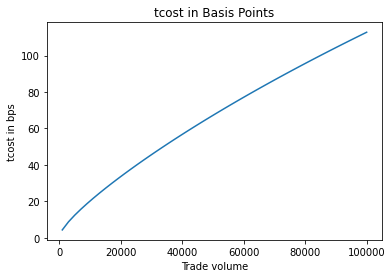

In [40]:
x = np.linspace(1000, 100000)
plt.plot(x, kissell(200000, 0.22, x));
plt.ylabel('tcost in bps')
plt.xlabel('Trade volume')
plt.title(r'tcost in Basis Points');

#### Zipline Volume Slippage Model

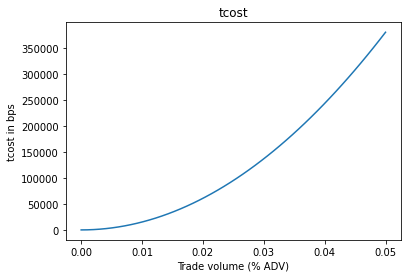

In [53]:
def zipline(pct_adv, minutes=1.0, minutes_in_day=60*6.5):
    day_frac = minutes / minutes_in_day
    tc_pct = 0.1 * abs(pct_adv/day_frac)**2
    return tc_pct*10000

x = np.linspace(0, 0.05)
plt.plot(x, zipline(x));
plt.ylabel('tcost in bps')
plt.xlabel('Trade volume (% ADV)')
plt.title(r'tcost');

## Comparison

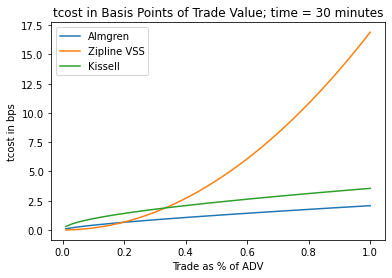

In [55]:
x = np.linspace(0.0001, 0.01)
plt.plot(x*100,tc_bps(x, 30, 0.20), label=r"Almgren");
plt.plot(x*100,zipline(x, minutes=30),label="Zipline VSS");
plt.plot(x*100,kissell(5*10**6,0.20, x*2000*10**3), label=r"Kissell");

plt.ylabel('tcost in bps')
plt.xlabel('Trade as % of ADV')
plt.title('tcost in Basis Points of Trade Value; time = 30 minutes');
plt.legend();